testing out new code...

In [2]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
# Install required packages
!pip install -U sentence-transformers

In [3]:
# Import necessary libraries
import pandas as pd
from collections import Counter
from sentence_transformers import SentenceTransformer
import numpy as np
import sklearn
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
)
import seaborn as sn
import matplotlib.pyplot as plt

In [4]:
# Load datasets
# Adjusting to the comma-separated format and proper headers
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/full dataset/train.csv")  # Train dataset has headers
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/full dataset/mal_full_offensive_test.csv", header=None, names=["text", "label"])  # Test dataset lacks headers

In [5]:
# Prepare data for training and testing
train_sent_m = train['text'].tolist()
train_label_m = train['label'].tolist()

test_sent_m = test['text'].tolist()
test_label_m = test['label'].tolist()

In [6]:
# Encode labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_label_m)
test_labels_encoded = le.fit_transform(test_label_m)

In [7]:
# Load multilingual embedding model
trans_model = SentenceTransformer('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [8]:
# Generate embeddings
train_sentence_embeddings = trans_model.encode(train_sent_m)
test_sentence_embeddings = trans_model.encode(test_sent_m)

In [9]:
# Compute class weights to handle imbalance
class_weights = sklearn.utils.class_weight.compute_class_weight(
    'balanced', classes=np.unique(train_labels_encoded), y=train_labels_encoded
)
print("Computed class weights:", class_weights)

Computed class weights: [ 0.22624179 16.76439791 22.87142857 13.39748954  2.48795649]



Evaluation Scores:
Macro Metrics:
Accuracy: 0.000
Precision: 0.339
Recall: 0.667
F1 Score: 0.011

Classification Report:
              precision    recall  f1-score   support

           0       0.02      1.00      0.03         1
           1       1.00      0.00      0.00      2001
           2       1.00      1.00      1.00         0
           3       1.00      1.00      1.00         0
           4       0.00      1.00      0.00         0

    accuracy                           0.00      2002
   macro avg       0.60      0.80      0.41      2002
weighted avg       1.00      0.00      0.00      2002

Predictions saved to 'Logistic_regression_predictions.csv'.


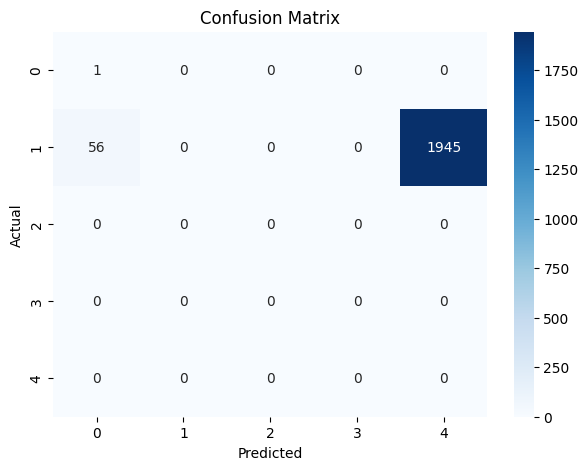

In [16]:
# Train Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Map class weights into dictionary format
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Initialize and train the model
model = LogisticRegression(class_weight=class_weight_dict, max_iter=500)
model.fit(train_sentence_embeddings, train_labels_encoded)

# Predict on the test data
expected = test_labels_encoded
predicted = model.predict(test_sentence_embeddings)

# Handle unseen labels in the test data
# Map unseen test labels to a default class to avoid evaluation errors
unique_train_labels = np.unique(train_labels_encoded)
filtered_expected = [label if label in unique_train_labels else -1 for label in expected]
filtered_predicted = [pred if pred in unique_train_labels else -1 for pred in predicted]

# Remove the default class (-1) from filtered labels for evaluation
filtered_expected = np.array(filtered_expected)
filtered_predicted = np.array(filtered_predicted)
valid_indices = filtered_expected != -1
filtered_expected = filtered_expected[valid_indices]
filtered_predicted = filtered_predicted[valid_indices]

# Evaluate model
print("\nEvaluation Scores:")
accuracy = accuracy_score(filtered_expected, filtered_predicted)
recall = recall_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
precision = precision_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
f1 = f1_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)

print("Macro Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Classification Report
# Fix LabelEncoder issue by fitting it on all possible labels before inverse_transform
all_possible_labels = np.unique(np.concatenate((train_labels_encoded, test_labels_encoded)))
le.fit(all_possible_labels)

# Convert target_names to strings
target_names = list(map(str, le.inverse_transform(unique_train_labels)))

print("\nClassification Report:")
print(classification_report(filtered_expected, filtered_predicted, labels=unique_train_labels, target_names=target_names, zero_division=1))

# Save predictions to a CSV file
# Use try-except to handle any unforeseen encoding issues
try:
    predictions = le.inverse_transform(predicted)
except ValueError:
    predictions = ["unseen_label" if pred not in unique_train_labels else le.inverse_transform([pred])[0] for pred in predicted]

classified_df = pd.DataFrame({'tweets': test_sent_m, 'actual_label': test_label_m, 'predictions': predictions})
classified_df.to_csv('Logistic_regression_predictions.csv', index=False)
print("Predictions saved to 'Logistic_regression_predictions.csv'.")

# Plot and save confusion matrix
cfm = confusion_matrix(filtered_expected, filtered_predicted, labels=unique_train_labels)
df_cfm = pd.DataFrame(cfm, index=target_names, columns=target_names)
plt.figure(figsize=(7, 5))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("cfm_LR.png")
plt.show()
